# Analyzing Flight Interconnected Data


###  Initialize PySpark Session


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg

# Create SparkSession with the necessary configurations
spark = SparkSession.builder \
    .appName("Air Flights") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.shuffle.service.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.ui.retainedStages", 100) \
    .config("spark.jars", "/opt/workspace/local/graphframes-0.8.1-spark3.0-s_2.12.jar") \
    .getOrCreate()

# Set the log level to 'WARN' to reduce verbosity
spark.sparkContext.setLogLevel("WARN")


25/01/05 13:06:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from pyspark.sql.functions import col, count, avg

# Data Loading


In [3]:
# Load the dataset
flights_df = spark.read.csv("local/2018.csv", header=True, inferSchema=True)
flights_df.show(5)

25/01/05 13:12:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|

###  Exploring Data

In [4]:
flights_df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: do

> Given the schema, we can define the vertices and edges as follows:

* Vertices: Unique airports from the ORIGIN and DEST columns.
* Edges: Each flight from an origin airport to a destination airport. (Weights are the count of number of flights from origin to dest).

### 1. Data Cleaning and Preparation (Graph creation)

In [5]:
flights_df = flights_df.na.drop(subset=["ORIGIN", "DEST"])


#### 1.1 Defining vertics

In [6]:
# Creating vertices DataFrame
airports_df = flights_df.select("ORIGIN").distinct().union(
    flights_df.select("DEST").distinct()
).distinct().withColumnRenamed("ORIGIN", "id")

# Displaying the vertices DataFrame
airports_df.show(5)


+---+
| id|
+---+
|BNA|
|CLT|
|TVC|
|CLL|
|CGI|
+---+
only showing top 5 rows



#### 1.2 Defining edges

In [7]:
edges_df = flights_df.groupBy("ORIGIN", "DEST").agg(
    count("*").alias("flight_count")
).withColumnRenamed("ORIGIN", "src").withColumnRenamed("DEST", "dst")

In [8]:
edges_df.show(5)

+---+---+------------+
|src|dst|flight_count|
+---+---+------------+
|ANC|DEN|         459|
|BNA|IAH|        1864|
|TPA|SFO|         381|
|ORD|PDX|        2762|
|ANC|OTZ|         671|
+---+---+------------+
only showing top 5 rows



In [9]:

from graphframes import GraphFrame

# Build the graph
graph = GraphFrame(airports_df,edges_df)




# 2. Calculate In-degree, out-degree and total degree

In [10]:
# In-degree, out-degree, total degree, and triangle count
in_degree = edges_df.groupBy("dst").agg(count("src").alias("in_degree"))
out_degree = edges_df.groupBy("src").agg(count("dst").alias("out_degree"))

# Combine degrees to calculate total degree
total_degree = in_degree.join(out_degree, in_degree.dst == out_degree.src, "outer") \
    .select(
        col("dst").alias("id"),
        col("in_degree"),
        col("out_degree"),
        (col("in_degree") + col("out_degree")).alias("total_degree")
    ).na.fill(0)
total_degree.show(5)


+---+---------+----------+------------+
| id|in_degree|out_degree|total_degree|
+---+---------+----------+------------+
|BGM|        1|         1|           2|
|BNA|       57|        57|         114|
|CGI|        2|         2|           4|
|CLL|        3|         2|           5|
|CLT|      136|       136|         272|
+---+---------+----------+------------+
only showing top 5 rows



In [11]:

# 1. Compute in-degree, out-degree, and total degree using GraphFrame 
in_degrees = graph.inDegrees
out_degrees = graph.outDegrees
total_degrees = in_degrees.join(out_degrees, "id", "outer") \
    .fillna(0) \
    .withColumn("total_degree", col("inDegree") + col("outDegree"))

# Display the degree results
total_degrees.show(5)


+---+--------+---------+------------+
| id|inDegree|outDegree|total_degree|
+---+--------+---------+------------+
|BGM|       1|        1|           2|
|BNA|      57|       57|         114|
|CGI|       2|        2|           4|
|CLL|       3|        2|           5|
|CLT|     136|      136|         272|
+---+--------+---------+------------+
only showing top 5 rows



# 3. count the Number  of triangles 

In [12]:
from pyspark.sql.functions import col, sum as _sum
from pyspark.sql.types import IntegerType

# Use a self-join approach for manual triangle counting
triangle_counts = edges_df.alias("e1") \
    .join(edges_df.alias("e2"), col("e1.dst") == col("e2.src")) \
    .join(edges_df.alias("e3"), (col("e2.dst") == col("e3.src")) & (col("e3.dst") == col("e1.src"))) \
    .groupBy("e1.src").count()

# Cast the 'count' column to integer
triangle_counts = triangle_counts.withColumn("count", col("count").cast(IntegerType()))

# Correctly aggregate and divide by 3 to avoid overcounting
total_triangles = triangle_counts.agg((_sum("count") / 3).alias("total_triangles")).collect()[0][0]

print(f"Total triangles: {total_triangles}")

Total triangles: 47532.0


In [13]:
# 2. Compute triangle counts with GraphFrames
triangle_counts = graph.triangleCount()
triangle_counts.show(5)

# Total number of triangles
total_triangles = triangle_counts.select("count").groupBy().sum().collect()[0][0]
print(f"Total number of triangles: {total_triangles}")


+-----+---+
|count| id|
+-----+---+
|    0|BGM|
| 1070|BNA|
|    1|CGI|
|    3|CLL|
| 1904|CLT|
+-----+---+
only showing top 5 rows



Total number of triangles: 72360


## 4. Compute centrality (e.g., closeness centrality)
 Note: Closeness centrality is not natively supported in GraphFrames
 ,we will compute degree centrality using the total degree as an approximation Because other approach need hug computionnel ressources (we tried shortest paths it took  more than 6 hours and we didn't get any results )


In [14]:

# Compute centrality 
centrality = total_degrees.withColumn("centrality", col("total_degree"))
centrality.show(5)

+---+--------+---------+------------+----------+
| id|inDegree|outDegree|total_degree|centrality|
+---+--------+---------+------------+----------+
|BGM|       1|        1|           2|         2|
|BNA|      57|       57|         114|       114|
|CGI|       2|        2|           4|         4|
|CLL|       3|        2|           5|         5|
|CLT|     136|      136|         272|       272|
+---+--------+---------+------------+----------+
only showing top 5 rows



## 5. Implementing Page Rank

In [15]:
from pyspark.sql.functions import col, lit, sum

# Initialize ranks
airports_df = airports_df.withColumn("rank", lit(1.0))

damping_factor = 0.85
max_iter = 10

for iteration in range(max_iter):
    # Join edges with ranks
    ranks_with_edges = edges_df.join(airports_df, edges_df.src == airports_df.id)\
                               .select("dst", "rank")

    # Calculate contributions
    contributions = ranks_with_edges.groupBy("dst")\
                                    .agg(sum("rank").alias("contributions"))

    # Update ranks
    airports_df = airports_df.join(contributions, airports_df.id == contributions.dst, "left_outer")\
                             .select(airports_df.id, 
                                     (col("contributions") * damping_factor + (1 - damping_factor)).alias("rank"))
    
    # Handling vertices without incoming edges
    airports_df = airports_df.na.fill(1.0 - damping_factor, ["rank"])


In [16]:
airports_df.orderBy("rank", ascending=False).show(5)

+---+--------------------+
| id|                rank|
+---+--------------------+
|ATL|8.291052955909923...|
|ORD|8.126526736172300...|
|DEN|8.029572613266470...|
|DFW|7.897698069076595...|
|CLT|7.442846123136857...|
+---+--------------------+
only showing top 5 rows




# 6. Analyze Most Connected Airports (the airport who has the most total  degree are  the most connected )
we tries another approach (which is the airport which has path to more nodes but it takes a lot of time (time to see all the path for each nodes and we can't diplay results)

In [17]:

most_connected = total_degree.orderBy("total_degree", ascending=False)
print("Most Important Airport are the most connected ones (more total degree) :")
most_connected.show(5)

Most Important Airport are the most connected ones (more total degree) :


+---+---------+----------+------------+
| id|in_degree|out_degree|total_degree|
+---+---------+----------+------------+
|ORD|      175|       174|         349|
|DFW|      169|       170|         339|
|ATL|      167|       166|         333|
|DEN|      164|       162|         326|
|CLT|      136|       136|         272|
+---+---------+----------+------------+
only showing top 5 rows



# 7. Find the Most Important Airport ( the airport which is ranked the most)


In [18]:
airports_df.orderBy("rank", ascending=False).show(1)

+---+--------------------+
| id|                rank|
+---+--------------------+
|ATL|8.291052955909923...|
+---+--------------------+
only showing top 1 row



# 8. Graph visualization 

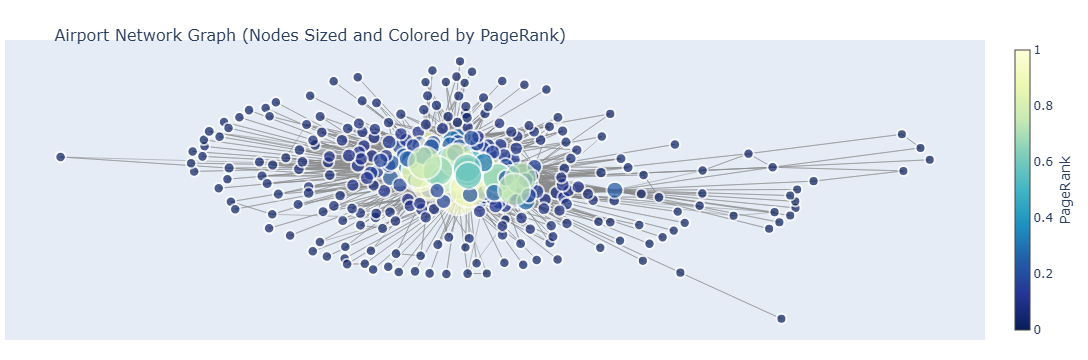

Graph saved successfully!


In [22]:
import networkx as nx
import plotly.graph_objs as go

# Convert Spark DataFrame to Pandas DataFrame
top_airports_pd = airports_df.toPandas()
top_edges_pd = edges_df.toPandas()

# Create a directed graph
G = nx.DiGraph()

# Add nodes with attributes (e.g., PageRank scores)
for idx, row in top_airports_pd.iterrows():
    G.add_node(row['id'], rank=row['rank'])

# Add edges
for idx, row in top_edges_pd.iterrows():
    G.add_edge(row['src'], row['dst'])

# Visualize the graph using Plotly
pos = nx.spring_layout(G)

# Edges
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Nodes
node_x = []
node_y = []
node_colors = []
node_sizes = []

# Extract maximum rank for normalization
max_rank = top_airports_pd['rank'].max()
min_rank = top_airports_pd['rank'].min()

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    
    # Get the rank of the node
    rank = G.nodes[node]['rank']
    
    # Normalize rank for size and color
    size = 10 + 30 * (rank - min_rank) / (max_rank - min_rank)  # Node size scaling
    color = (rank - min_rank) / (max_rank - min_rank)  # Normalized color intensity
    
    node_sizes.append(size)
    node_colors.append(color)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        size=node_sizes,  # Use the calculated sizes
        color=node_colors,  # Use the calculated colors
        colorbar=dict(
            thickness=15,
            title='PageRank',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    )
)

# Add hover text for nodes
node_text = []
for node in G.nodes():
    node_text.append(f"Airport: {node}<br>Rank: {G.nodes[node]['rank']:.4f}")
node_trace.text = node_text

# Draw the graph
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Airport Network Graph (Nodes Sized and Colored by PageRank)',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
)

# Display the graph
fig.show()

# Save to HTML file
try:
    fig.write_html("airport_network_graph.html")
    print("Graph saved successfully!")
except Exception as e:
    print(f"Error saving graph: {e}")
